In [901]:
# Copyright (c) 2019 Nikhil Singh
# GNU General Public License v3.0+ (see COPYING or https://www.gnu.org/licenses/gpl-3.0.txt)
# name: Prosumers (House, School, Zoo, Gym and Event hall) power consumption forecast
#       via LR, KNN, GBR, MLP, Ridge, Lasso and AKNN.
# author: Nikhil Singh (nikkytub@gmail.com)
# data-source: Karlsruhe Institute of Technology ("https://im.iism.kit.edu/sciber.php") and ISIS homework-3

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from lpi_python import lpi_distance, lpi_mean
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import datetime
import time

In [902]:
data_prosumers = pd.read_table('SCiBER.txt')
data_house = pd.read_csv('Excercise3-data.csv', parse_dates=True)

In [903]:
# 02.01.2015 to 01.12.2016
dp = data_prosumers[70079:137279:4]
dp.index = range(16800)
# 02.01.2015 to 01.12.2016
dh = data_house[36:33636:2]
dh = dh.drop('Building 2', axis=1)
dh.index = range(16800)
date = dh.loc[:,'Unnamed: 0']
house = dh.loc[:,'Building 1']
school = dp.loc[:,'School']
zoo = dp.loc[:,'Zoo']
gym = dp.loc[:, 'Gym.1']
hall = dp.loc[:, 'Event hall']
temp = dh.loc[:,'Temperature']
x = pd.DataFrame(index=range(16800))
x.loc[:,"Date"] = date
x.loc[:,"Pr-1(House) load in kW"] = house
x.loc[:,"Pr-2(School) load in kW"] = school
x.loc[:,"Pr-3(Zoo) load in kW"] = zoo
x.loc[:,"Pr-4(Gym) load in kW"] = gym
x.loc[:,"Pr-5(Event hall) load in kW"] = hall
x.loc[:,"Temperature"] = temp
x['Date'] = pd.to_datetime(x['Date'])
x["month_of_year"] = x['Date'].dt.month
x["hour_of_day"] = x['Date'].dt.hour
x["day_of_week"] = x['Date'].dt.dayofweek

In [904]:
X_pr1 = pd.DataFrame(index=x.index)
X_pr2 = pd.DataFrame(index=x.index)
X_pr3 = pd.DataFrame(index=x.index)
X_pr4 = pd.DataFrame(index=x.index)
X_pr5 = pd.DataFrame(index=x.index)

In [905]:
lags = [1,2,3,4,5,6,24,48,168]
for lag in lags:
    X_pr1.loc[:,"lag_"+str(lag)] = house.shift(lag)
for lag in lags:
    X_pr2.loc[:,"lag_"+str(lag)] = school.shift(lag)
for lag in lags:
    X_pr3.loc[:,"lag_"+str(lag)] = zoo.shift(lag)
for lag in lags:
    X_pr4.loc[:,"lag_"+str(lag)] = gym.shift(lag)
for lag in lags:
    X_pr5.loc[:,"lag_"+str(lag)] = hall.shift(lag)

In [906]:
X_pr1.loc[:,"HoD"] = x["hour_of_day"]
X_pr1.loc[:,"DoW"] = x["day_of_week"]
X_pr1.loc[:,"MoY"] = x["month_of_year"]
X_pr1.loc[:,"Temperature"] = x["Temperature"]

X_pr2.loc[:,"HoD"] = x["hour_of_day"]
X_pr2.loc[:,"DoW"] = x["day_of_week"]
X_pr2.loc[:,"MoY"] = x["month_of_year"]
X_pr2.loc[:,"Temperature"] = x["Temperature"]

X_pr3.loc[:,"HoD"] = x["hour_of_day"]
X_pr3.loc[:,"DoW"] = x["day_of_week"]
X_pr3.loc[:,"MoY"] = x["month_of_year"]
X_pr3.loc[:,"Temperature"] = x["Temperature"]

X_pr4.loc[:,"HoD"] = x["hour_of_day"]
X_pr4.loc[:,"DoW"] = x["day_of_week"]
X_pr4.loc[:,"MoY"] = x["month_of_year"]
X_pr4.loc[:,"Temperature"] = x["Temperature"]

X_pr5.loc[:,"HoD"] = x["hour_of_day"]
X_pr5.loc[:,"DoW"] = x["day_of_week"]
X_pr5.loc[:,"MoY"] = x["month_of_year"]
X_pr5.loc[:,"Temperature"] = x["Temperature"]


In [907]:
# One-hot encoding
X_pr1 = pd.get_dummies(X_pr1, columns=["HoD", "DoW", "MoY"])

X_pr2 = pd.get_dummies(X_pr2, columns=["HoD", "DoW", "MoY"])

X_pr3 = pd.get_dummies(X_pr3, columns=["HoD", "DoW", "MoY"])

X_pr4 = pd.get_dummies(X_pr4, columns=["HoD", "DoW", "MoY"])

X_pr5 = pd.get_dummies(X_pr5, columns=["HoD", "DoW", "MoY"])


In [908]:
Y_pr1 = house
Y_pr2 = school
Y_pr3 = zoo
Y_pr4 = gym
Y_pr5 = hall

In [909]:
# Train/Test Split
X_train_pr1, X_test_pr1, y_train_pr1, y_test_pr1 = train_test_split(X_pr1.iloc[168:,:], Y_pr1.iloc[168:], test_size=0.0014, shuffle=False)
X_train_pr2, X_test_pr2, y_train_pr2, y_test_pr2 = train_test_split(X_pr2.iloc[168:,:], Y_pr2.iloc[168:], test_size=0.0014, shuffle=False)
X_train_pr3, X_test_pr3, y_train_pr3, y_test_pr3 = train_test_split(X_pr3.iloc[168:,:], Y_pr3.iloc[168:], test_size=0.0014, shuffle=False)
X_train_pr4, X_test_pr4, y_train_pr4, y_test_pr4 = train_test_split(X_pr4.iloc[168:,:], Y_pr4.iloc[168:], test_size=0.0014, shuffle=False)
X_train_pr5, X_test_pr5, y_train_pr5, y_test_pr5 = train_test_split(X_pr5.iloc[168:,:], Y_pr5.iloc[168:], test_size=0.0014, shuffle=False)


In [925]:
def step_graph(prediction, actual, ylabl, xlabl):
    hour = []
    for i in range(24):
        hour.append(i)
    plt.step(hour, prediction, label='Predicted')
    plt.step(hour, actual.values, label='Actual')
    plt.ylabel(ylabl)
    plt.xticks([0, 5, 10, 15, 20],
               ['00:00', '05:00', '10:00', '15:00', '20:00'])
    plt.xlabel(xlabl)
    plt.legend()
    return plt.show()


def continuous_graph(prediction, actual, ylabl, xlabl):
    plt.plot(prediction, label='Predicted')
    plt.plot(actual.values, label='Actual')
    plt.ylabel(ylabl)
    plt.xticks([0, 5, 10, 15, 20],
               ['00:00', '05:00', '10:00', '15:00', '20:00'])
    plt.xlabel(xlabl)
    plt.legend()
    return plt.show()


def mae(y_true, y_pred):
    '''Mean Absolute Error'''
    return np.average(np.abs(y_pred - y_true))

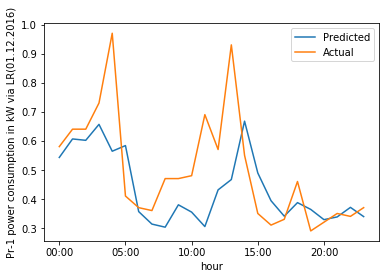

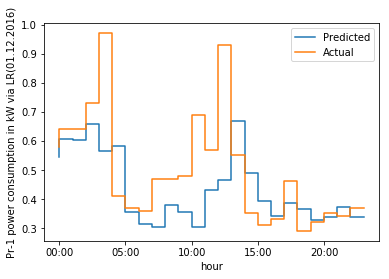

MAE Pr-1 LR: 0.12
NRMSE Pr-1 LR: 0.34 



In [930]:
# Linear regression Pr-1
lr_pr1 = LinearRegression()
lr_pr1.fit(X_train_pr1, y_train_pr1)
lr_pr1_hat = lr_pr1.predict(X_test_pr1)

continuous_graph(lr_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via LR(01.12.2016)', 'hour')
step_graph(lr_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via LR(01.12.2016)', 'hour')

mean_pr1 = np.mean(y_test_pr1)
mse_pr1_lr = mean_squared_error(y_test_pr1, lr_pr1_hat)
rmse_pr1_lr = math.sqrt(mse_pr1_lr)
nrmse_pr1_lr = rmse_pr1_lr / mean_pr1
print("MAE Pr-1 LR: {:.2f}" .format(mae(y_test_pr1, lr_pr1_hat)))
print('NRMSE Pr-1 LR: {:.2f}'.format(nrmse_pr1_lr), "\n")


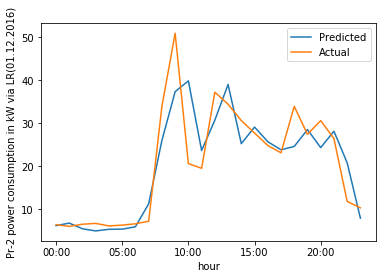

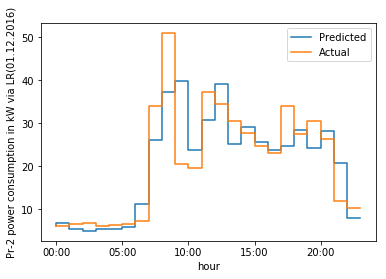

MAE Pr-2 LR: 4.35
NRMSE Pr-2 LR: 0.31 



In [931]:
# Linear regression Pr-2
lr_pr2 = LinearRegression()
lr_pr2.fit(X_train_pr2, y_train_pr2)
lr_pr2_hat = lr_pr2.predict(X_test_pr2)

continuous_graph(lr_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via LR(01.12.2016)', 'hour')
step_graph(lr_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via LR(01.12.2016)', 'hour')

mean_pr2 = np.mean(y_test_pr2)
mse_pr2_lr = mean_squared_error(y_test_pr2, lr_pr2_hat)
rmse_pr2_lr = math.sqrt(mse_pr2_lr)
nrmse_pr2_lr = rmse_pr2_lr / mean_pr2
print("MAE Pr-2 LR: {:.2f}" .format(mae(y_test_pr2, lr_pr2_hat)))
print('NRMSE Pr-2 LR: {:.2f}'.format(nrmse_pr2_lr), "\n")

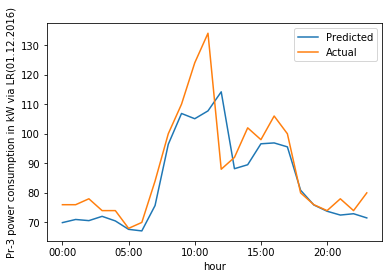

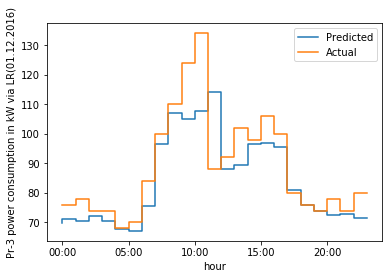

MAE Pr-3 LR: 6.70
NRMSE Pr-3 LR: 0.11 



In [932]:
# Linear regression Pr-3
lr_pr3 = LinearRegression()
lr_pr3.fit(X_train_pr3, y_train_pr3)
lr_pr3_hat = lr_pr3.predict(X_test_pr3)

continuous_graph(lr_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via LR(01.12.2016)', 'hour')
step_graph(lr_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via LR(01.12.2016)', 'hour')

mean_pr3 = np.mean(y_test_pr3)
mse_pr3_lr = mean_squared_error(y_test_pr3, lr_pr3_hat)
rmse_pr3_lr = math.sqrt(mse_pr3_lr)
nrmse_pr3_lr = rmse_pr3_lr / mean_pr3
print("MAE Pr-3 LR: {:.2f}" .format(mae(y_test_pr3, lr_pr3_hat)))
print('NRMSE Pr-3 LR: {:.2f}'.format(nrmse_pr3_lr), "\n")

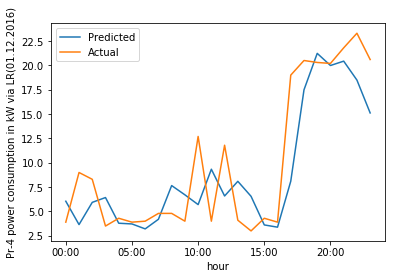

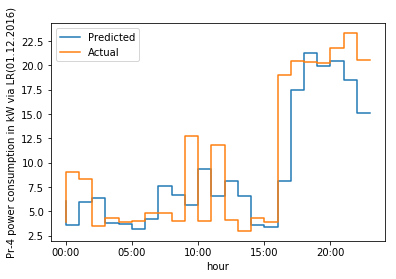

MAE Pr-4 LR: 3.06
NRMSE Pr-4 LR: 0.40 



In [936]:
# Linear regression Pr-4
lr_pr4 = LinearRegression()
lr_pr4.fit(X_train_pr4, y_train_pr4)
lr_pr4_hat = lr_pr4.predict(X_test_pr4)

continuous_graph(lr_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via LR(01.12.2016)', 'hour')
step_graph(lr_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via LR(01.12.2016)', 'hour')

mean_pr4 = np.mean(y_test_pr4)
mse_pr4_lr = mean_squared_error(y_test_pr4, lr_pr4_hat)
rmse_pr4_lr = math.sqrt(mse_pr4_lr)
nrmse_pr4_lr = rmse_pr4_lr / mean_pr4
print("MAE Pr-4 LR: {:.2f}" .format(mae(y_test_pr4, lr_pr4_hat)))
print('NRMSE Pr-4 LR: {:.2f}'.format(nrmse_pr4_lr), "\n")


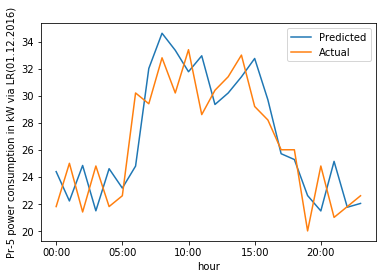

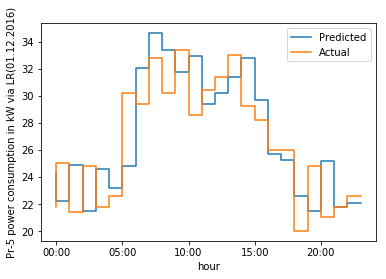

MAE Pr-5 LR: 2.29
NRMSE Pr-5 LR: 0.10 



In [935]:
# Linear regression Pr-5
lr_pr5 = LinearRegression()
lr_pr5.fit(X_train_pr5, y_train_pr5)
lr_pr5_hat = lr_pr5.predict(X_test_pr5)

continuous_graph(lr_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via LR(01.12.2016)', 'hour')
step_graph(lr_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via LR(01.12.2016)', 'hour')

mean_pr5 = np.mean(y_test_pr5)
mse_pr5_lr = mean_squared_error(y_test_pr5, lr_pr5_hat)
rmse_pr5_lr = math.sqrt(mse_pr5_lr)
nrmse_pr5_lr = rmse_pr5_lr / mean_pr5
print("MAE Pr-5 LR: {:.2f}" .format(mae(y_test_pr5, lr_pr5_hat)))
print('NRMSE Pr-5 LR: {:.2f}'.format(nrmse_pr5_lr), "\n")

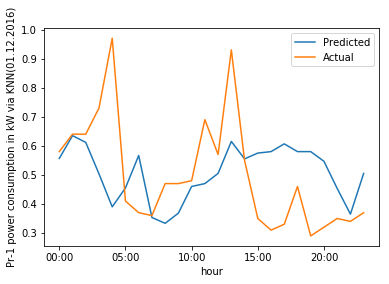

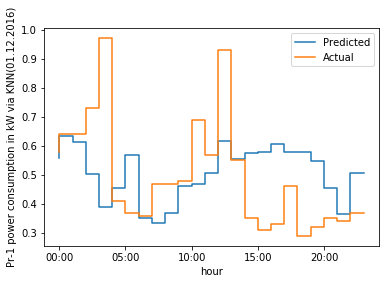

MAE Pr-1 KNN: 0.15
NRMSE Pr-1 KNN: 0.41 



In [937]:
# KNN Pr1
knn_pr1 = KNeighborsRegressor(n_neighbors=6)
knn_pr1.fit(X_train_pr1, y_train_pr1)
y_pr1_hat = knn_pr1.predict(X_test_pr1)

continuous_graph(y_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via KNN(01.12.2016)', 'hour')
step_graph(y_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via KNN(01.12.2016)', 'hour')

mse_pr1_knn = mean_squared_error(y_test_pr1, y_pr1_hat)
rmse_pr1_knn = math.sqrt(mse_pr1_knn)
nrmse_pr1_knn = rmse_pr1_knn / mean_pr1
print("MAE Pr-1 KNN: {:.2f}" .format(mae(y_test_pr1, y_pr1_hat)))
print('NRMSE Pr-1 KNN: {:.2f}'.format(nrmse_pr1_knn), "\n")

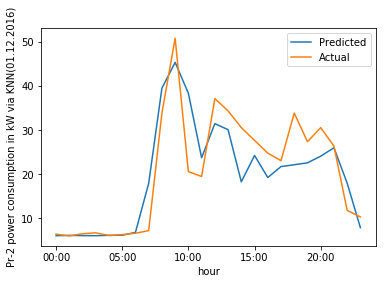

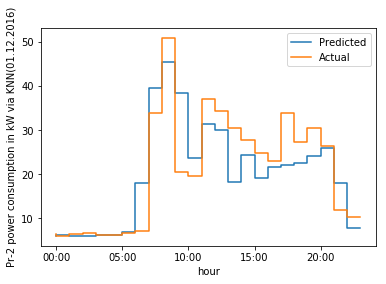

MAE Pr-2 KNN: 4.60
NRMSE Pr-2 KNN: 0.31 



In [938]:
# KNN Pr2
knn_pr2 = KNeighborsRegressor(n_neighbors=6)
knn_pr2.fit(X_train_pr2, y_train_pr2)
y_pr2_hat = knn_pr2.predict(X_test_pr2)

continuous_graph(y_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via KNN(01.12.2016)', 'hour')
step_graph(y_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via KNN(01.12.2016)', 'hour')

mse_pr2_knn = mean_squared_error(y_test_pr2, y_pr2_hat)
rmse_pr2_knn = math.sqrt(mse_pr2_knn)
nrmse_pr2_knn = rmse_pr2_knn / mean_pr2
print("MAE Pr-2 KNN: {:.2f}" .format(mae(y_test_pr2, y_pr2_hat)))
print('NRMSE Pr-2 KNN: {:.2f}'.format(nrmse_pr2_knn), "\n")

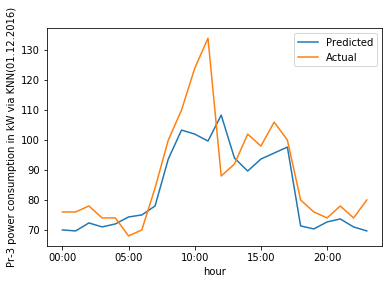

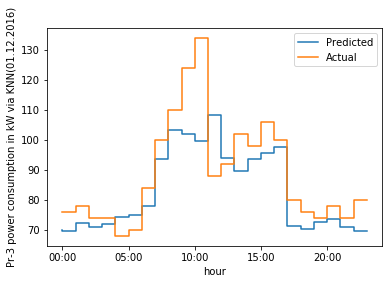

MAE Pr-3 KNN: 8.11
NRMSE Pr-3 KNN: 0.12 



In [939]:
# KNN Pr3
knn_pr3 = KNeighborsRegressor(n_neighbors=6)
knn_pr3.fit(X_train_pr3, y_train_pr3)
y_pr3_hat = knn_pr3.predict(X_test_pr3)

continuous_graph(y_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via KNN(01.12.2016)', 'hour')
step_graph(y_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via KNN(01.12.2016)', 'hour')

mse_pr3_knn = mean_squared_error(y_test_pr3, y_pr3_hat)
rmse_pr3_knn = math.sqrt(mse_pr3_knn)
nrmse_pr3_knn = rmse_pr3_knn / mean_pr3
print("MAE Pr-3 KNN: {:.2f}" .format(mae(y_test_pr3, y_pr3_hat)))
print('NRMSE Pr-3 KNN: {:.2f}'.format(nrmse_pr3_knn), "\n")

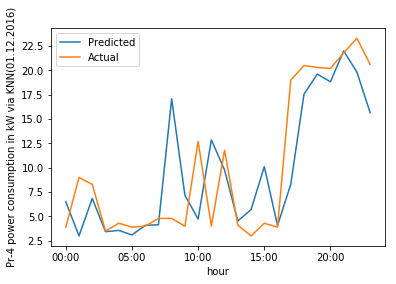

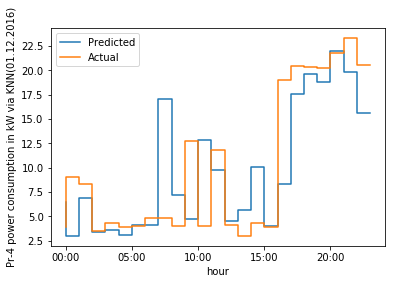

MAE Pr-4 KNN: 3.34
NRMSE Pr-4 KNN: --> 0.48 



In [940]:
# KNN Pr4
knn_pr4 = KNeighborsRegressor(n_neighbors=6)
knn_pr4.fit(X_train_pr4, y_train_pr4)
y_pr4_hat = knn_pr4.predict(X_test_pr4)

continuous_graph(y_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via KNN(01.12.2016)', 'hour')
step_graph(y_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via KNN(01.12.2016)', 'hour')

mse_pr4_knn = mean_squared_error(y_test_pr4, y_pr4_hat)
rmse_pr4_knn = math.sqrt(mse_pr4_knn)
nrmse_pr4_knn = rmse_pr4_knn / mean_pr4
print("MAE Pr-4 KNN: {:.2f}" .format(mae(y_test_pr4, y_pr4_hat)))
print('NRMSE Pr-4 KNN: --> {:.2f}'.format(nrmse_pr4_knn), "\n")

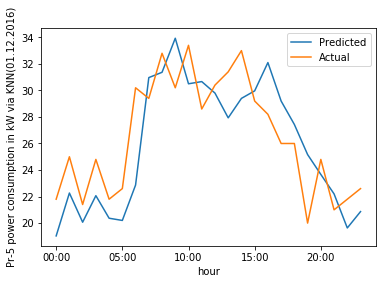

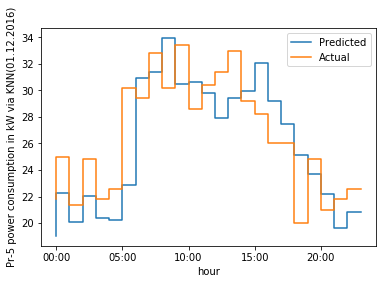

MAE Pr-5 KNN: 2.53
NRMSE Pr-5 KNN: 0.11 



In [941]:
# KNN Pr5
knn_pr5 = KNeighborsRegressor(n_neighbors=6)
knn_pr5.fit(X_train_pr5, y_train_pr5)
y_pr5_hat = knn_pr5.predict(X_test_pr5)

continuous_graph(y_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via KNN(01.12.2016)', 'hour')
step_graph(y_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via KNN(01.12.2016)', 'hour')

mse_pr5_knn = mean_squared_error(y_test_pr5, y_pr5_hat)
rmse_pr5_knn = math.sqrt(mse_pr5_knn)
nrmse_pr5_knn = rmse_pr5_knn / mean_pr5
print("MAE Pr-5 KNN: {:.2f}" .format(mae(y_test_pr5, y_pr5_hat)))
print('NRMSE Pr-5 KNN: {:.2f}'.format(nrmse_pr5_knn), "\n")

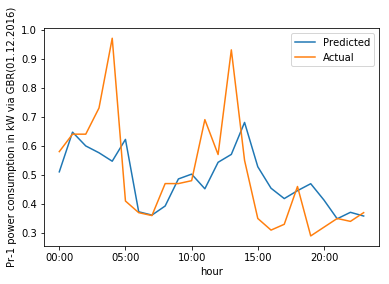

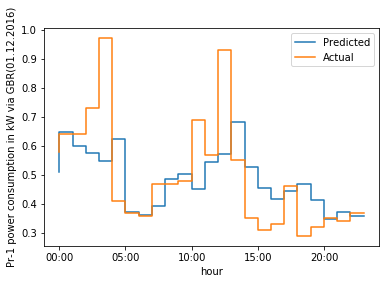

MAE Pr-1 GBR: 0.11
NRMSE Pr-1 GBR: 0.31 



In [942]:
# Gradient boosting regression Pr-1
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr_pr1 = GradientBoostingRegressor(**params)
gbr_pr1.fit(X_train_pr1, y_train_pr1)
gbr_pr1_hat = gbr_pr1.predict(X_test_pr1)

continuous_graph(gbr_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via GBR(01.12.2016)', 'hour')
step_graph(gbr_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via GBR(01.12.2016)', 'hour')

mse_pr1_gbr = mean_squared_error(y_test_pr1, gbr_pr1_hat)
rmse_pr1_gbr = math.sqrt(mse_pr1_gbr)
nrmse_pr1_gbr = rmse_pr1_gbr / mean_pr1
print("MAE Pr-1 GBR: {:.2f}" .format(mae(y_test_pr1, gbr_pr1_hat)))
print('NRMSE Pr-1 GBR: {:.2f}'.format(nrmse_pr1_gbr), "\n")

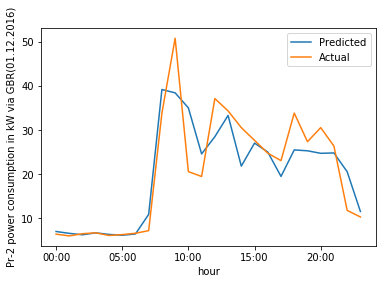

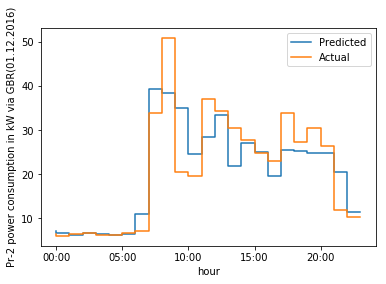

MAE Pr-2 GBR: 3.91
NRMSE Pr-2 GBR: 0.28 



In [943]:
# Gradient boosting regression Pr-2
gbr_pr2 = GradientBoostingRegressor(**params)
gbr_pr2.fit(X_train_pr2, y_train_pr2)
gbr_pr2_hat = gbr_pr2.predict(X_test_pr2)

continuous_graph(gbr_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via GBR(01.12.2016)', 'hour')
step_graph(gbr_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via GBR(01.12.2016)', 'hour')

mse_pr2_gbr = mean_squared_error(y_test_pr2, gbr_pr2_hat)
rmse_pr2_gbr = math.sqrt(mse_pr2_gbr)
nrmse_pr2_gbr = rmse_pr2_gbr / mean_pr2
print("MAE Pr-2 GBR: {:.2f}" .format(mae(y_test_pr2, gbr_pr2_hat)))
print('NRMSE Pr-2 GBR: {:.2f}'.format(nrmse_pr2_gbr), "\n")

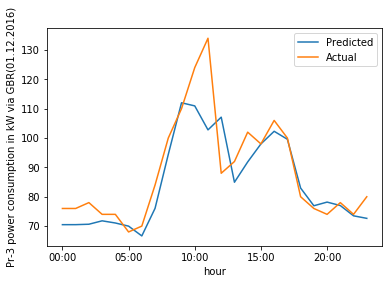

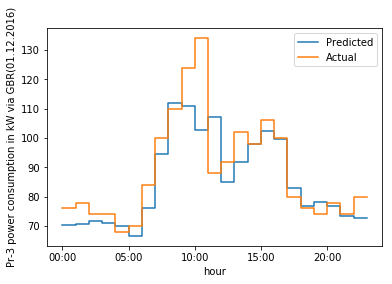

MAE Pr-3 GBR: 6.09
NRMSE Pr-3 GBR: 0.10 



In [944]:
# Gradient boosting regression Pr-3
gbr_pr3 = GradientBoostingRegressor(**params)
gbr_pr3.fit(X_train_pr3, y_train_pr3)
gbr_pr3_hat = gbr_pr3.predict(X_test_pr3)

continuous_graph(gbr_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via GBR(01.12.2016)', 'hour')
step_graph(gbr_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via GBR(01.12.2016)', 'hour')

mse_pr3_gbr = mean_squared_error(y_test_pr3, gbr_pr3_hat)
rmse_pr3_gbr = math.sqrt(mse_pr3_gbr)
nrmse_pr3_gbr = rmse_pr3_gbr / mean_pr3
print("MAE Pr-3 GBR: {:.2f}" .format(mae(y_test_pr3, gbr_pr3_hat)))
print('NRMSE Pr-3 GBR: {:.2f}'.format(nrmse_pr3_gbr), "\n")

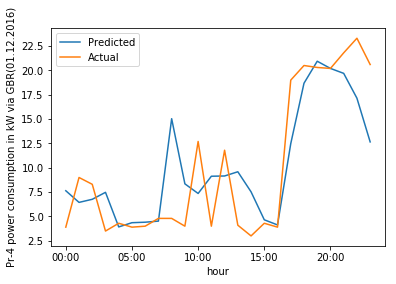

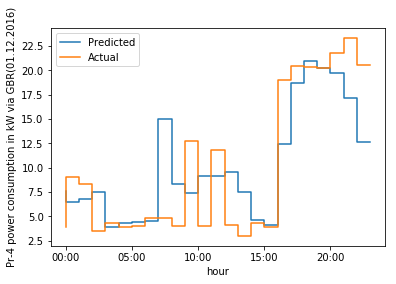

MAE Pr-4 GBR: 3.20
NRMSE Pr-4 GBR: 0.42 



In [945]:
# Gradient boosting regression Pr-4
gbr_pr4 = GradientBoostingRegressor(**params)
gbr_pr4.fit(X_train_pr4, y_train_pr4)
gbr_pr4_hat = gbr_pr4.predict(X_test_pr4)

continuous_graph(gbr_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via GBR(01.12.2016)', 'hour')
step_graph(gbr_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via GBR(01.12.2016)', 'hour')

mse_pr4_gbr = mean_squared_error(y_test_pr4, gbr_pr4_hat)
rmse_pr4_gbr = math.sqrt(mse_pr4_gbr)
nrmse_pr4_gbr = rmse_pr4_gbr / mean_pr4
print("MAE Pr-4 GBR: {:.2f}" .format(mae(y_test_pr4, gbr_pr4_hat)))
print('NRMSE Pr-4 GBR: {:.2f}'.format(nrmse_pr4_gbr), "\n")


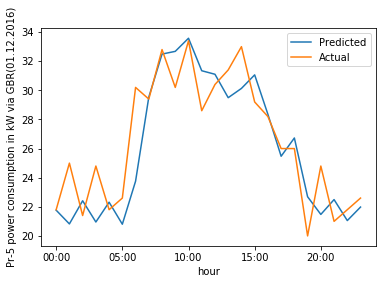

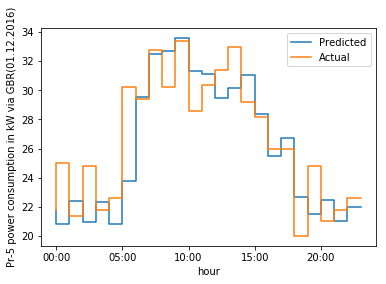

MAE Pr-5 GBR: 1.72
NRMSE Pr-5 GBR: 0.09 



In [947]:
# Gradient boosting regression Pr-5
gbr_pr5 = GradientBoostingRegressor(**params)
gbr_pr5.fit(X_train_pr5, y_train_pr5)
gbr_pr5_hat = gbr_pr5.predict(X_test_pr5)

continuous_graph(gbr_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via GBR(01.12.2016)', 'hour')
step_graph(gbr_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via GBR(01.12.2016)', 'hour')

mse_pr5_gbr = mean_squared_error(y_test_pr5, gbr_pr5_hat)
rmse_pr5_gbr = math.sqrt(mse_pr5_gbr)
nrmse_pr5_gbr = rmse_pr5_gbr / mean_pr5
print("MAE Pr-5 GBR: {:.2f}" .format(mae(y_test_pr5, gbr_pr5_hat)))
print('NRMSE Pr-5 GBR: {:.2f}'.format(nrmse_pr5_gbr), "\n")


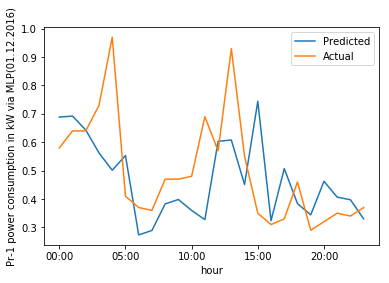

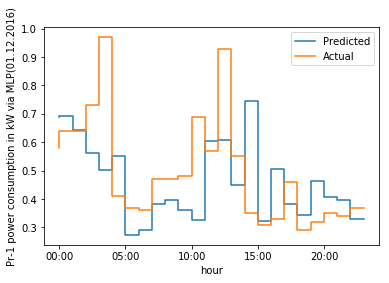

MAE Pr-1 MLP: 0.13
NRMSE Pr-1 MLP: 0.36 



In [948]:
# MLP Pr-1
mlp_pr1 = MLPRegressor()
mlp_pr1.fit(X_train_pr1, y_train_pr1)
m_pr1_hat = mlp_pr1.predict(X_test_pr1)

continuous_graph(m_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via MLP(01.12.2016)', 'hour')
step_graph(m_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via MLP(01.12.2016)', 'hour')

mse_pr1_mlp = mean_squared_error(y_test_pr1, m_pr1_hat)
rmse_pr1_mlp = math.sqrt(mse_pr1_mlp)
nrmse_pr1_mlp = rmse_pr1_mlp / mean_pr1
print("MAE Pr-1 MLP: {:.2f}" .format(mae(y_test_pr1, m_pr1_hat)))
print('NRMSE Pr-1 MLP: {:.2f}'.format(nrmse_pr1_mlp), "\n")

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


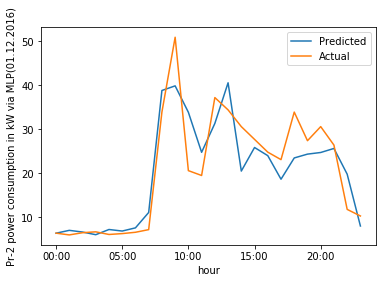

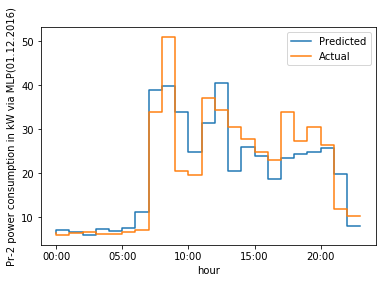

MAE Pr-2 MLP: 4.27
NRMSE Pr-2 MLP: 0.28 



In [949]:
# MLP Pr-2
mlp_pr2 = MLPRegressor()
mlp_pr2.fit(X_train_pr2, y_train_pr2)
m_pr2_hat = mlp_pr2.predict(X_test_pr2)

continuous_graph(m_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via MLP(01.12.2016)', 'hour')
step_graph(m_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via MLP(01.12.2016)', 'hour')

mse_pr2_mlp = mean_squared_error(y_test_pr2, m_pr2_hat)
rmse_pr2_mlp = math.sqrt(mse_pr2_mlp)
nrmse_pr2_mlp = rmse_pr2_mlp / mean_pr2
print("MAE Pr-2 MLP: {:.2f}" .format(mae(y_test_pr2, m_pr2_hat)))
print('NRMSE Pr-2 MLP: {:.2f}'.format(nrmse_pr2_mlp), "\n")

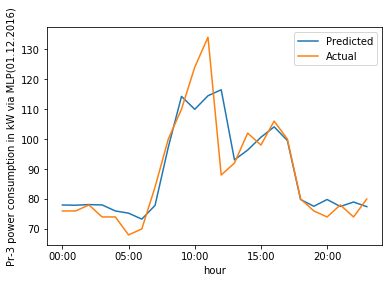

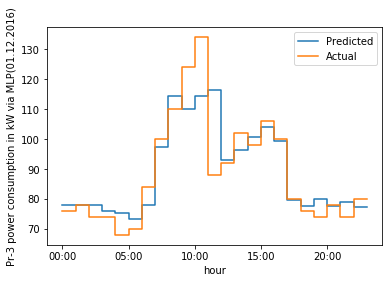

MAE Pr-3 MLP: 5.13
NRMSE Pr-3 MLP 0.09 



In [950]:
# MLP Pr-3
mlp_pr3 = MLPRegressor()
mlp_pr3.fit(X_train_pr3, y_train_pr3)
m_pr3_hat = mlp_pr3.predict(X_test_pr3)

continuous_graph(m_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via MLP(01.12.2016)', 'hour')
step_graph(m_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via MLP(01.12.2016)', 'hour')

mse_pr3_mlp = mean_squared_error(y_test_pr3, m_pr3_hat)
rmse_pr3_mlp = math.sqrt(mse_pr3_mlp)
nrmse_pr3_mlp = rmse_pr3_mlp / mean_pr3
print("MAE Pr-3 MLP: {:.2f}" .format(mae(y_test_pr3, m_pr3_hat)))
print('NRMSE Pr-3 MLP {:.2f}'.format(nrmse_pr3_mlp), "\n")

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


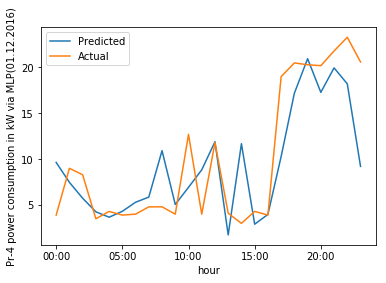

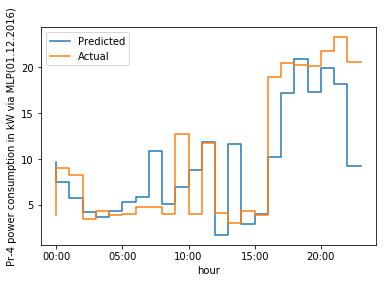

MAE Pr-4 MLP: 3.26
NRMSE Pr-4 MLP: 0.45 



In [952]:

# MLP Pr-4
mlp_pr4 = MLPRegressor()
mlp_pr4.fit(X_train_pr4, y_train_pr4)
m_pr4_hat = mlp_pr4.predict(X_test_pr4)

continuous_graph(m_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via MLP(01.12.2016)', 'hour')
step_graph(m_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via MLP(01.12.2016)', 'hour')

mse_pr4_mlp = mean_squared_error(y_test_pr4, m_pr4_hat)
rmse_pr4_mlp = math.sqrt(mse_pr4_mlp)
nrmse_pr4_mlp = float(rmse_pr4_mlp / mean_pr4)
print("MAE Pr-4 MLP: {:.2f}" .format(mae(y_test_pr4, m_pr4_hat)))
print('NRMSE Pr-4 MLP: {:.2f}'.format(nrmse_pr4_mlp), "\n")

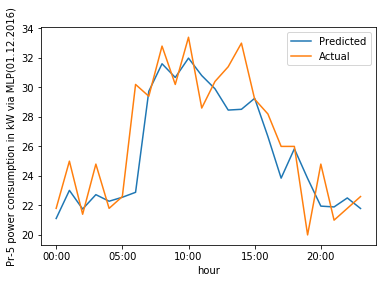

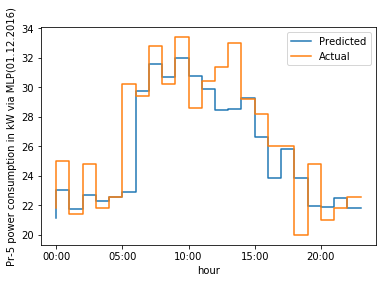

MAE Pr-5 MLP: 1.64
NRMSE Pr-5 MLP: 0.09 



In [953]:
# MLP Pr-5
mlp_pr5 = MLPRegressor()
mlp_pr5.fit(X_train_pr5, y_train_pr5)
m_pr5_hat = mlp_pr5.predict(X_test_pr5)

continuous_graph(m_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via MLP(01.12.2016)', 'hour')
step_graph(m_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via MLP(01.12.2016)', 'hour')

mse_pr5_mlp = mean_squared_error(y_test_pr5, m_pr5_hat)
rmse_pr5_mlp = math.sqrt(mse_pr5_mlp)
nrmse_pr5_mlp = rmse_pr5_mlp / mean_pr5
print("MAE Pr-5 MLP: {:.2f}" .format(mae(y_test_pr5, m_pr5_hat)))
print('NRMSE Pr-5 MLP: {:.2f}'.format(nrmse_pr5_mlp), "\n")

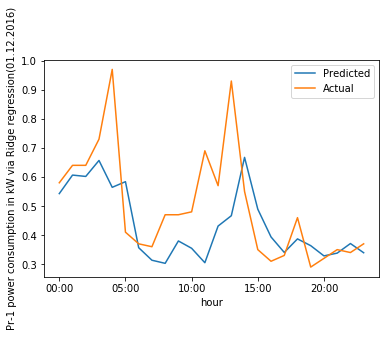

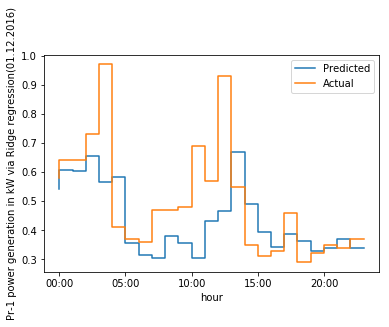

MAE Pr-1 Ridge: 0.12
NRMSE Pr-1 Ridge: 0.34 



In [954]:
# Ridge Pr-1
r_pr1 = Ridge()
r_pr1.fit(X_train_pr1, y_train_pr1)
r_pr1_hat = r_pr1.predict(X_test_pr1)
continuous_graph(r_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via Ridge regression(01.12.2016)',
                 'hour')
step_graph(r_pr1_hat, y_test_pr1, 'Pr-1 power generation in kW via Ridge regression(01.12.2016)', 'hour')

mse_pr1_r = mean_squared_error(y_test_pr1, r_pr1_hat)
rmse_pr1_r = math.sqrt(mse_pr1_r)
nrmse_pr1_r = rmse_pr1_r / mean_pr1
print("MAE Pr-1 Ridge: {:.2f}" .format(mae(y_test_pr1, r_pr1_hat)))
print('NRMSE Pr-1 Ridge: {:.2f}'.format(nrmse_pr1_r), "\n")

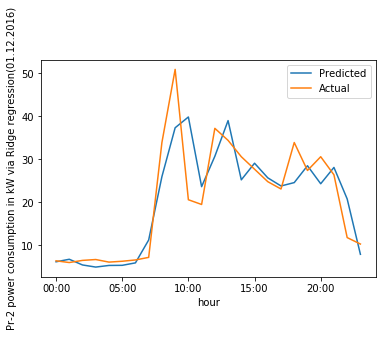

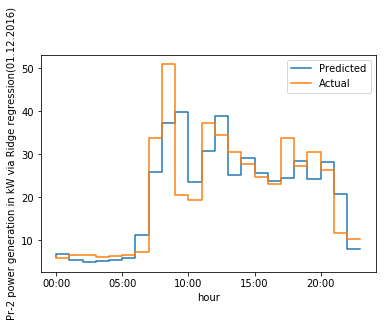

MAE Pr-2 Ridge: 4.35
NRMSE Pr-2 Ridge: 0.31 



In [956]:
# Ridge Pr-2
r_pr2 = Ridge()
r_pr2.fit(X_train_pr2, y_train_pr2)
r_pr2_hat = r_pr2.predict(X_test_pr2)
continuous_graph(r_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via Ridge regression(01.12.2016)',
                 'hour')
step_graph(r_pr2_hat, y_test_pr2, 'Pr-2 power generation in kW via Ridge regression(01.12.2016)', 'hour')

mse_pr2_r = mean_squared_error(y_test_pr2, r_pr2_hat)
rmse_pr2_r = math.sqrt(mse_pr2_r)
nrmse_pr2_r = rmse_pr2_r / mean_pr2
print("MAE Pr-2 Ridge: {:.2f}" .format(mae(y_test_pr2, r_pr2_hat)))
print('NRMSE Pr-2 Ridge: {:.2f}'.format(nrmse_pr2_r), "\n")

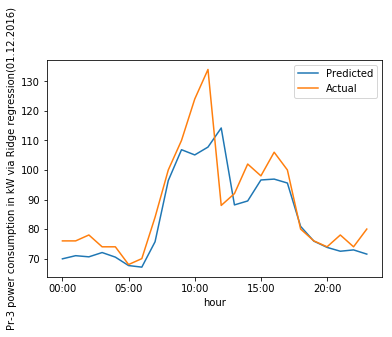

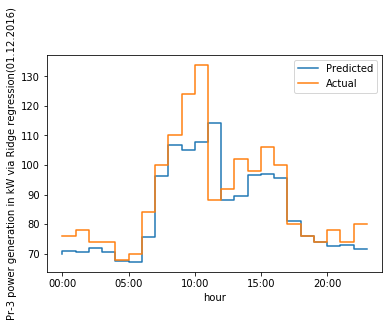

MAE Pr-3 Ridge: 6.71
NRMSE Pr-3 Ridge: 0.11 



In [957]:
# Ridge Pr-3
r_pr3 = Ridge()
r_pr3.fit(X_train_pr3, y_train_pr3)
r_pr3_hat = r_pr3.predict(X_test_pr3)
continuous_graph(r_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via Ridge regression(01.12.2016)',
                 'hour')
step_graph(r_pr3_hat, y_test_pr3, 'Pr-3 power generation in kW via Ridge regression(01.12.2016)', 'hour')

mse_pr3_r = mean_squared_error(y_test_pr3, r_pr3_hat)
rmse_pr3_r = math.sqrt(mse_pr3_r)
nrmse_pr3_r = rmse_pr3_r / mean_pr3
print("MAE Pr-3 Ridge: {:.2f}" .format(mae(y_test_pr3, r_pr3_hat)))
print('NRMSE Pr-3 Ridge: {:.2f}'.format(nrmse_pr3_r), "\n")

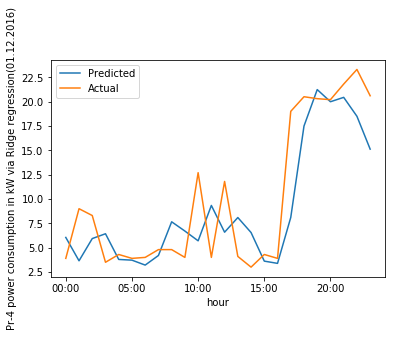

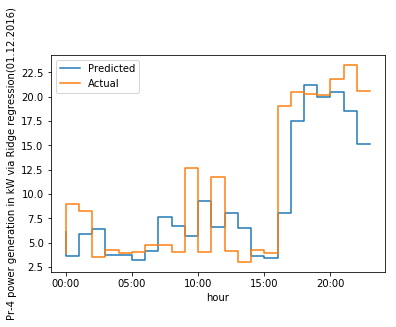

MAE Pr-4 Ridge: 3.06
NRMSE Pr-4 Ridge: 0.40 



In [959]:
# Ridge Pr-4
r_pr4 = Ridge()
r_pr4.fit(X_train_pr4, y_train_pr4)
r_pr4_hat = r_pr4.predict(X_test_pr4)
continuous_graph(r_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via Ridge regression(01.12.2016)',
                 'hour')
step_graph(r_pr4_hat, y_test_pr4, 'Pr-4 power generation in kW via Ridge regression(01.12.2016)', 'hour')

mse_pr4_r = mean_squared_error(y_test_pr4, r_pr4_hat)
rmse_pr4_r = math.sqrt(mse_pr4_r)
nrmse_pr4_r = rmse_pr4_r / mean_pr4
print("MAE Pr-4 Ridge: {:.2f}" .format(mae(y_test_pr4, r_pr4_hat)))
print('NRMSE Pr-4 Ridge: {:.2f}'.format(nrmse_pr4_r), "\n")

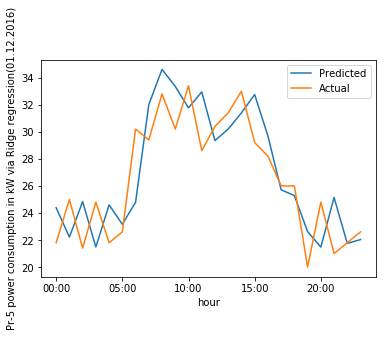

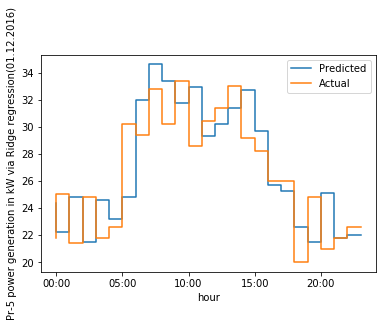

MAE Pr-5 Ridge: 2.29
NRMSE Pr-5 Ridge: 0.10 



In [960]:
# Ridge Pr-5
r_pr5 = Ridge()
r_pr5.fit(X_train_pr5, y_train_pr5)
r_pr5_hat = r_pr5.predict(X_test_pr5)
continuous_graph(r_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via Ridge regression(01.12.2016)',
                 'hour')
step_graph(r_pr5_hat, y_test_pr5, 'Pr-5 power generation in kW via Ridge regression(01.12.2016)', 'hour')

mse_pr5_r = mean_squared_error(y_test_pr5, r_pr5_hat)
rmse_pr5_r = math.sqrt(mse_pr5_r)
nrmse_pr5_r = rmse_pr5_r / mean_pr5
print("MAE Pr-5 Ridge: {:.2f}" .format(mae(y_test_pr5, r_pr5_hat)))
print('NRMSE Pr-5 Ridge: {:.2f}'.format(nrmse_pr5_r), "\n")

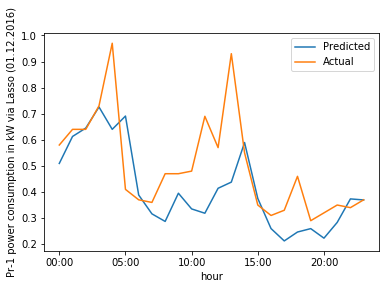

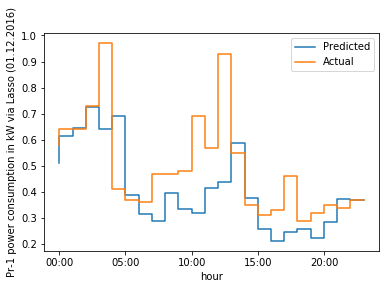

MAE Pr-1 Lasso: 0.12
NRMSE Pr-1 Lasso: 0.35 



In [961]:
# Lasso Pr-1
lasso_pr1 = Lasso(alpha=0.01)
lasso_pr1.fit(X_train_pr1, y_train_pr1)
lasso_pr1_hat = lasso_pr1.predict(X_test_pr1)

continuous_graph(lasso_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via Lasso (01.12.2016)', 'hour')
step_graph(lasso_pr1_hat, y_test_pr1, 'Pr-1 power consumption in kW via Lasso (01.12.2016)', 'hour')

mse_pr1_l = mean_squared_error(y_test_pr1, lasso_pr1_hat)
rmse_pr1_l = math.sqrt(mse_pr1_l)
nrmse_pr1_l = rmse_pr1_l / mean_pr1
print("MAE Pr-1 Lasso: {:.2f}" .format(mae(y_test_pr1, lasso_pr1_hat)))
print('NRMSE Pr-1 Lasso: {:.2f}'.format(nrmse_pr1_l), "\n")

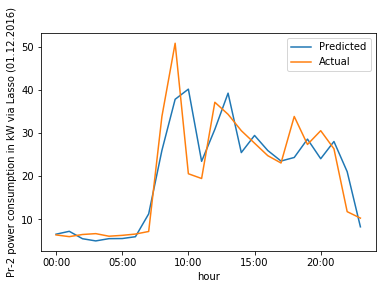

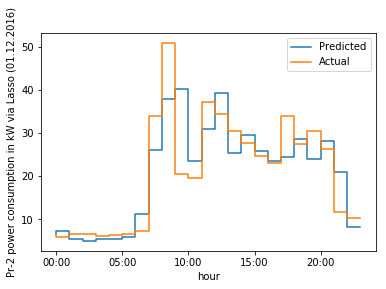

MAE Pr-2 Lasso: 4.36
NRMSE Pr-2 Lasso: 0.31 



In [962]:
# Lasso Pr-2
lasso_pr2 = Lasso(alpha=0.01)
lasso_pr2.fit(X_train_pr2, y_train_pr2)
lasso_pr2_hat = lasso_pr2.predict(X_test_pr2)

continuous_graph(lasso_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via Lasso (01.12.2016)', 'hour')
step_graph(lasso_pr2_hat, y_test_pr2, 'Pr-2 power consumption in kW via Lasso (01.12.2016)', 'hour')

mse_pr2_l = mean_squared_error(y_test_pr2, lasso_pr2_hat)
rmse_pr2_l = math.sqrt(mse_pr2_l)
nrmse_pr2_l = rmse_pr2_l / mean_pr2
print("MAE Pr-2 Lasso: {:.2f}" .format(mae(y_test_pr2, lasso_pr2_hat)))
print('NRMSE Pr-2 Lasso: {:.2f}'.format(nrmse_pr2_l), "\n")

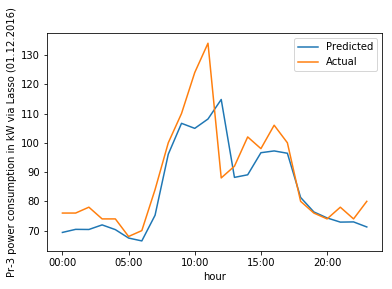

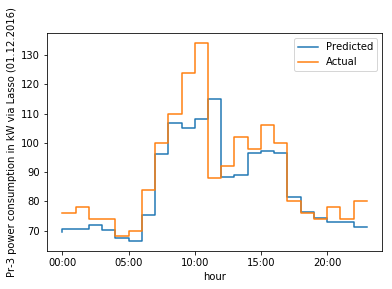

MAE Pr-3 Lasso: 6.86
NRMSE Pr-3 Lasso: 0.11 



In [963]:
# Lasso Pr-3
lasso_pr3 = Lasso(alpha=0.01)
lasso_pr3.fit(X_train_pr3, y_train_pr3)
lasso_pr3_hat = lasso_pr3.predict(X_test_pr3)

continuous_graph(lasso_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via Lasso (01.12.2016)', 'hour')
step_graph(lasso_pr3_hat, y_test_pr3, 'Pr-3 power consumption in kW via Lasso (01.12.2016)', 'hour')

mse_pr3_l = mean_squared_error(y_test_pr3, lasso_pr3_hat)
rmse_pr3_l = math.sqrt(mse_pr3_l)
nrmse_pr3_l = rmse_pr3_l / mean_pr3
print("MAE Pr-3 Lasso: {:.2f}" .format(mae(y_test_pr3, lasso_pr3_hat)))
print('NRMSE Pr-3 Lasso: {:.2f}'.format(nrmse_pr3_l), "\n")

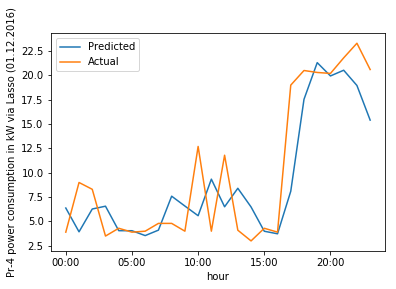

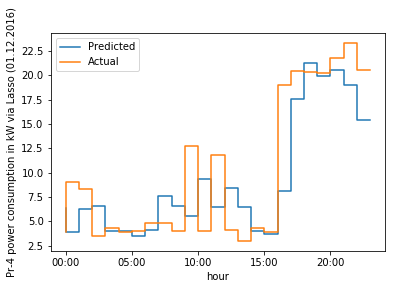

MAE Pr-4 Lasso: 2.98
NRMSE Pr-4 Lasso: 0.40 



In [964]:
# Lasso Pr-4
lasso_pr4 = Lasso(alpha=0.01)
lasso_pr4.fit(X_train_pr4, y_train_pr4)
lasso_pr4_hat = lasso_pr4.predict(X_test_pr4)

continuous_graph(lasso_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via Lasso (01.12.2016)', 'hour')
step_graph(lasso_pr4_hat, y_test_pr4, 'Pr-4 power consumption in kW via Lasso (01.12.2016)', 'hour')

mse_pr4_l = mean_squared_error(y_test_pr4, lasso_pr4_hat)
rmse_pr4_l = math.sqrt(mse_pr4_l)
nrmse_pr4_l = rmse_pr4_l / mean_pr4
print("MAE Pr-4 Lasso: {:.2f}" .format(mae(y_test_pr4, lasso_pr4_hat)))
print('NRMSE Pr-4 Lasso: {:.2f}'.format(nrmse_pr4_l), "\n")

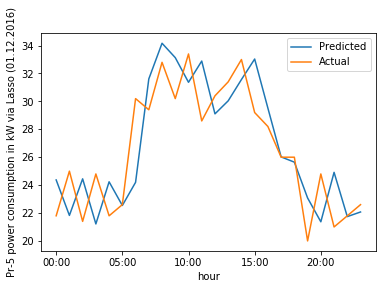

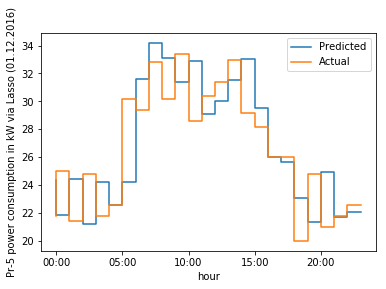

MAE Pr-5 Lasso: 2.26
NRMSE Pr-5 Lasso: 0.10 



In [965]:
# Lasso Pr-5
lasso_pr5 = Lasso(alpha=0.01)
lasso_pr5.fit(X_train_pr5, y_train_pr5)
lasso_pr5_hat = lasso_pr5.predict(X_test_pr5)

continuous_graph(lasso_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via Lasso (01.12.2016)', 'hour')
step_graph(lasso_pr5_hat, y_test_pr5, 'Pr-5 power consumption in kW via Lasso (01.12.2016)', 'hour')

mse_pr5_l = mean_squared_error(y_test_pr5, lasso_pr5_hat)
rmse_pr5_l = math.sqrt(mse_pr5_l)
nrmse_pr5_l = rmse_pr5_l / mean_pr5
print("MAE Pr-5 Lasso: {:.2f}" .format(mae(y_test_pr5, lasso_pr5_hat)))
print('NRMSE Pr-5 Lasso: {:.2f}'.format(nrmse_pr5_l), "\n")

In [966]:
# AKNN
# 02/01/2015 to 30/11/2016
ini_data = x[:16776]

# 30/11/2016
prev_day_data = x[16752:16776]

# 01/12/2016
last_day_data = x[16776:]

In [967]:
y_test_pr1_01_12 = last_day_data['Pr-1(House) load in kW']
y_test_pr2_01_12 = last_day_data['Pr-2(School) load in kW']
y_test_pr3_01_12 = last_day_data['Pr-3(Zoo) load in kW']
y_test_pr4_01_12 = last_day_data['Pr-4(Gym) load in kW']
y_test_pr5_01_12 = last_day_data['Pr-5(Event hall) load in kW']

load_pr1_30_11 = np.array(prev_day_data['Pr-1(House) load in kW'])
load_pr2_30_11 = np.array(prev_day_data['Pr-2(School) load in kW'])
load_pr3_30_11 = np.array(prev_day_data['Pr-3(Zoo) load in kW'])
load_pr4_30_11 = np.array(prev_day_data['Pr-4(Gym) load in kW'])
load_pr5_30_11 = np.array(prev_day_data['Pr-5(Event hall) load in kW'])

y_train_pr1 = np.array(ini_data['Pr-1(House) load in kW'])
y_train_pr2 = np.array(ini_data['Pr-2(School) load in kW'])
y_train_pr3 = np.array(ini_data['Pr-3(Zoo) load in kW'])
y_train_pr4 = np.array(ini_data['Pr-4(Gym) load in kW'])
y_train_pr5 = np.array(ini_data['Pr-5(Event hall) load in kW'])

In [968]:
chunks_pr1 = [y_train_pr1[x:x + 24] for x in range(0, len(y_train_pr1), 24)]
chunks_pr2 = [y_train_pr2[x:x + 24] for x in range(0, len(y_train_pr2), 24)]
chunks_pr3 = [y_train_pr3[x:x + 24] for x in range(0, len(y_train_pr3), 24)]
chunks_pr4 = [y_train_pr4[x:x + 24] for x in range(0, len(y_train_pr4), 24)]
chunks_pr5 = [y_train_pr5[x:x + 24] for x in range(0, len(y_train_pr5), 24)]

time_last_day = np.array(last_day_data['Date'])

In [969]:
def aknn(load, chunks):
    x_generation = []
    dist = []
    d1_dist = dict()
    for x in chunks:
        x_generation.append(x)
        d = lpi_distance(load, x)
        dist.append(d)
        d1_dist.update({d:x})
    sorted_dict = dict()
    for key in sorted(d1_dist.keys()):
        sorted_dict.update({key: d1_dist[key]})
    d1_generation = []
    for key in sorted_dict.keys():
        d1_generation.append(sorted_dict[key])
    m = lpi_mean(d1_generation[:6])
    return m


def prediction(load, chunks):
    aknn_predicted_load = [aknn(load, chunks)]
    plot_values = []
    for pred in aknn_predicted_load:
        for l in pred:
            plot_values.append(l)
    return plot_values

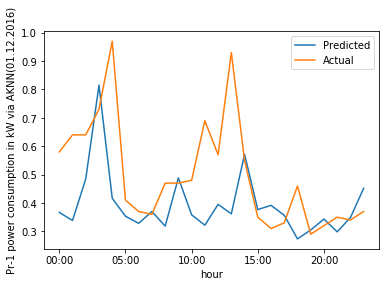

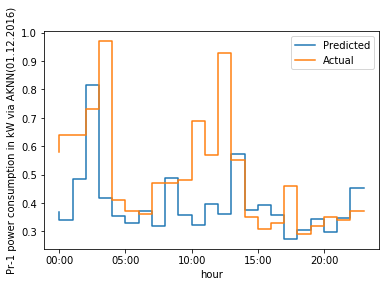

MAE Pr-1 AKNN: 0.14
NRMSE Pr-1 AKNN: 0.42 



In [971]:
# AKNN Pr-1
plot_values_pr1 = prediction(load_pr1_30_11, chunks_pr1)
continuous_graph(plot_values_pr1, y_test_pr1_01_12, 'Pr-1 power consumption in kW via AKNN(01.12.2016)', 'hour')
step_graph(plot_values_pr1, y_test_pr1_01_12, 'Pr-1 power consumption in kW via AKNN(01.12.2016)', 'hour')

mse_pr1_aknn = mean_squared_error(y_test_pr1_01_12, plot_values_pr1)
rmse_pr1_aknn = math.sqrt(mse_pr1_aknn)
nrmse_pr1_aknn = rmse_pr1_aknn / mean_pr1
print("MAE Pr-1 AKNN: {:.2f}" .format(mae(y_test_pr1_01_12, plot_values_pr1)))
print('NRMSE Pr-1 AKNN: {:.2f}'.format(nrmse_pr1_aknn), "\n")

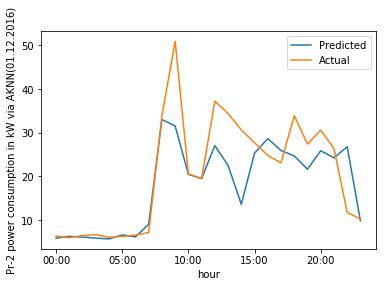

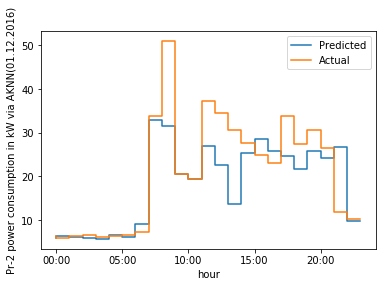

MAE Pr-2 AKNN: 4.61
NRMSE Pr-2 AKNN: 0.36 



In [972]:
# AKNN Pr-2
plot_values_pr2 = prediction(load_pr2_30_11, chunks_pr2)
continuous_graph(plot_values_pr2, y_test_pr2_01_12, 'Pr-2 power consumption in kW via AKNN(01.12.2016)', 'hour')
step_graph(plot_values_pr2, y_test_pr2_01_12, 'Pr-2 power consumption in kW via AKNN(01.12.2016)', 'hour')

mse_pr2_aknn = mean_squared_error(y_test_pr2_01_12, plot_values_pr2)
rmse_pr2_aknn = math.sqrt(mse_pr2_aknn)
nrmse_pr2_aknn = rmse_pr2_aknn / mean_pr2
print("MAE Pr-2 AKNN: {:.2f}" .format(mae(y_test_pr2_01_12, plot_values_pr2)))
print('NRMSE Pr-2 AKNN: {:.2f}'.format(nrmse_pr2_aknn), "\n")

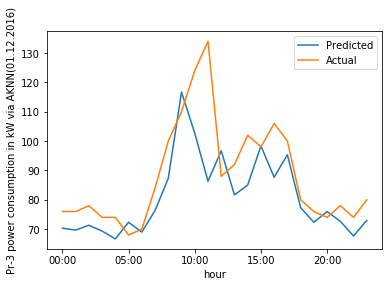

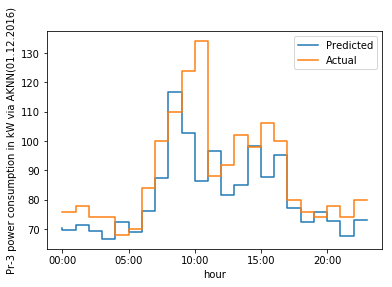

MAE Pr-3 AKNN: 9.10
NRMSE Pr-3 AKNN: 0.15 



In [974]:
# AKNN Pr-3
plot_values_pr3 = prediction(load_pr3_30_11, chunks_pr3)
continuous_graph(plot_values_pr3, y_test_pr3_01_12, 'Pr-3 power consumption in kW via AKNN(01.12.2016)', 'hour')
step_graph(plot_values_pr3, y_test_pr3_01_12, 'Pr-3 power consumption in kW via AKNN(01.12.2016)', 'hour')

mse_pr3_aknn = mean_squared_error(y_test_pr3_01_12, plot_values_pr3)
rmse_pr3_aknn = math.sqrt(mse_pr3_aknn)
nrmse_pr3_aknn = rmse_pr3_aknn / mean_pr3
print("MAE Pr-3 AKNN: {:.2f}" .format(mae(y_test_pr3_01_12, plot_values_pr3)))
print('NRMSE Pr-3 AKNN: {:.2f}'.format(nrmse_pr3_aknn), "\n")

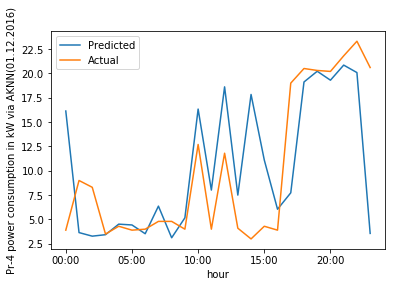

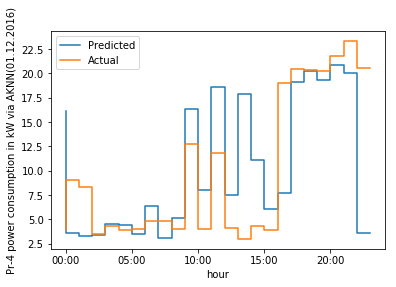

MAE Pr-4 AKNN: 4.37
NRMSE Pr-4 AKNN: 0.65 



In [975]:
# AKNN Pr-4
plot_values_pr4 = prediction(load_pr4_30_11, chunks_pr4)
continuous_graph(plot_values_pr4, y_test_pr4_01_12, 'Pr-4 power consumption in kW via AKNN(01.12.2016)', 'hour')
step_graph(plot_values_pr4, y_test_pr4_01_12, 'Pr-4 power consumption in kW via AKNN(01.12.2016)', 'hour')

mse_pr4_aknn = mean_squared_error(y_test_pr4_01_12, plot_values_pr4)
rmse_pr4_aknn = math.sqrt(mse_pr4_aknn)
nrmse_pr4_aknn = rmse_pr4_aknn / mean_pr4
print("MAE Pr-4 AKNN: {:.2f}" .format(mae(y_test_pr4_01_12, plot_values_pr4)))
print('NRMSE Pr-4 AKNN: {:.2f}'.format(nrmse_pr4_aknn), "\n")

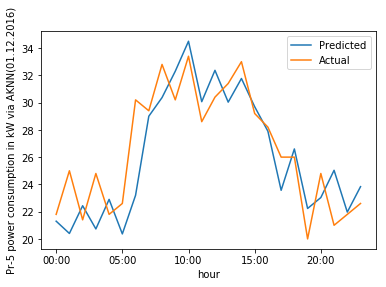

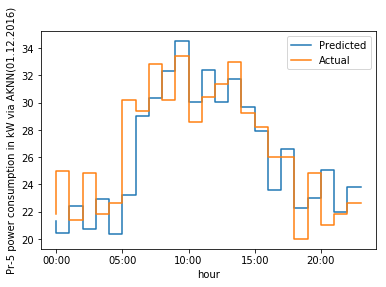

MAE Pr-5 AKNN: 1.91
NRMSE Pr-5 AKNN: 0.09 



In [976]:
# AKNN Pr-5
plot_values_pr5 = prediction(load_pr5_30_11, chunks_pr5)
continuous_graph(plot_values_pr5, y_test_pr5_01_12, 'Pr-5 power consumption in kW via AKNN(01.12.2016)', 'hour')
step_graph(plot_values_pr5, y_test_pr5_01_12, 'Pr-5 power consumption in kW via AKNN(01.12.2016)', 'hour')
mse_pr5_aknn = mean_squared_error(y_test_pr5_01_12, plot_values_pr5)
rmse_pr5_aknn = math.sqrt(mse_pr5_aknn)
nrmse_pr5_aknn = rmse_pr5_aknn / mean_pr5
print("MAE Pr-5 AKNN: {:.2f}" .format(mae(y_test_pr5_01_12, plot_values_pr5)))
print('NRMSE Pr-5 AKNN: {:.2f}'.format(nrmse_pr5_aknn), "\n")

In [978]:
# To create a csv file of forecast which can be used for optimization
date_time = ["Date"]
for a in time_last_day:
    date_time.append(a)

# Pr1 via GBR
prediction_pr1 = ["Pr-1 load in kW"]
for a in gbr_pr1_hat:
    prediction_pr1.append(a)

# Pr2 via GBR
prediction_pr2 = ["Pr-2 load in kW"]
for a in gbr_pr2_hat:
    prediction_pr2.append(a)

# Pr3 via MLP
prediction_pr3 = ["Pr-3 load in kW"]
for a in m_pr3_hat:
    prediction_pr3.append(a)

# Pr4 via LR
prediction_pr4 = ["Pr-4 load in kW"]
for a in lr_pr4_hat:
    prediction_pr4.append(a)

# Pr5 via AKNN
prediction_pr5 = ["Pr-5 load in kW"]
for a in plot_values_pr5:
    prediction_pr5.append(a)

    
zip_time_and_forecast = zip(date_time, prediction_pr1, prediction_pr2, prediction_pr3, prediction_pr4, prediction_pr5)
x = tuple(zip_time_and_forecast)
with open('result_prosumers.csv', 'w') as csvFile:
    for a in x:
        writer = csv.writer(csvFile)
        writer.writerow(a)